# Geospatial data processing

Today we're going to look at pulling climate statistics out for suburbs from a shapefile. First let's look at the libraries we're going to use

In [1]:
import geopandas
import shapely
import pandas
import numpy
import rasterio
import affine
import numpy as np

We're using `geopandas` to manage the vector data, and `rasterio` to manage the raster data. You can find the documentation for these libraries here:

- [`geopandas` documentation](http://geopandas.org) - uses `shapely` and `pandas` under the hood to manage geometries and tabular attributes respectively.
- [`rasterio` documentation](https://rasterio.readthedocs.io/en/latest/) - uses `numpy` and `affine` under the hood to manage arrays and transformations respectively.

Feel free to have a browse around and see what else these libraries can do for you. There's also a specialized StackExchange (like a subreddit for StackOverflow) on geospatial stuff here: https://gis.stackexchange.com which typically has a higher signal-to-noise ratio if you get stuck.

### Downloading and parsing BoM climate data

I've downloaded the BoM data for Australia from here: http://www.bom.gov.au/jsp/ncc/climate_averages/temperature/index.jsp?maptype=3&period=aut#maps

BoM, in it's own wisdom, uses a Grid text file which has no useful geospatial aspects so we need a seperate function to put it into a useful format. Feel free to dumpster dive if you want to see how to generate your own geotiffs from numpy arrays otherwise just ignore this function and treat it as a black-box conversion service.

In [2]:
def grid_to_geotiff(filename, return_data=False):
    """ Load data from a Bureau of Meterology 'grid' file and dump out to geotiff
        Output is written to geotiff
        Parameters:
            filename - the file name of the BoM grid file to convert
            return_data - if true, then a Numpy array with the imported
                data is returned when conversion is successful.
    """
    # First six lines are metadata
    # Note: gonna assume the origin is WGS84
    with open(filename) as fhandle:
        meta = {}
        for line in fhandle:
            key, value = line.split()
            key = key.lower()
            meta[key] = value
            if len(meta) == 6:
                break

    # Handle sloppy labelling from BoM
    for idx in ('x', 'y'):
        if meta.get(idx + 'llcorner') is not None:
            meta[idx + 'llcenter'] = meta[idx + 'llcorner']

    # Convert metadata to right format
    type_mapping = {'ncols': int, 'nrows': int,
                    'xllcenter': float, 'yllcenter': float,
                    'cellsize': float, 'nodata_value': float}
    for key, typef in type_mapping.items():
        meta[key] = typef(meta[key])

    # Next lines are info - swap out nodata with nans
    # Last lines are also metadata 'header' but we don't care about that
    data = numpy.genfromtxt(filename, dtype=numpy.float64,
                            skip_header=6, skip_footer=18)

    # Check whether we have masked values to deal with
    has_mask = (meta.get('nodata_value') is not None)
    if has_mask:
        has_mask = True
        nodata_mask = (data - meta['nodata_value']) ** 2 < 1e-6

    ## MAKE GEOTIFF
    # Generate the transform for the grid
    aff = affine.Affine.translation(
        meta['xllcenter'] - meta['cellsize'] * 0.5,
        meta['yllcenter'] + (meta['nrows'] - 0.5) * meta['cellsize']
    ) * affine.Affine.scale(meta['cellsize'], -meta['cellsize'])

    # Make metadata for geotiff
    geotiff_meta = {
        'transform': aff,
        'width': meta['ncols'],
        'height': meta['nrows'],
        'nodata': meta['nodata_value'],
        'tiled': 'no',
        'crs': {'init': 'epsg:4326'},  # assuming WGS84
        'driver': 'GTiff',
        'dtype': 'float64',
        'blockxsize': 128,
        'blockysize': 128,
        'count': 1
    }

    # Write out to file
    with rasterio.open(filename + '.geotiff', 'w', **geotiff_meta) as sink:
        sink.write_band(1, data)
        if has_mask:
            sink.write_mask(nodata_mask.astype(bool))

    # If we're returning the data, convert data mask to numpy.nan
    if return_data:
        if has_mask:
            data[nodata_mask] = numpy.nan
        return data
    else:
        return filename + '.geotiff'

Now lets use this importer to read the grid file and convert it to a georeferenced GeoTIFF

In [3]:
data = {
    'spring': grid_to_geotiff('../data/minspr.txt', return_data=True),
    'summer': grid_to_geotiff('../data/minsum.txt', return_data=True),
    'autumn': grid_to_geotiff('../data/minaut.txt', return_data=True),
    'winter': grid_to_geotiff('../data/minwin.txt', return_data=True)
}

We can show a quick-and-dirty plot of Australia's minimum temperatures for each season

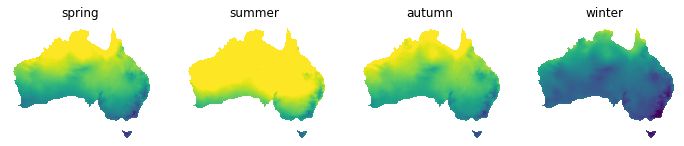

In [4]:
import matplotlib.pyplot as plt

# Set the min and maximum so everything uses the same scale
min_temp = -1
max_temp = 20

# Generate the plots for each season
fig, axes = plt.subplots(1, 4)
for (title, temps), ax in zip(data.items(), axes):
    ax.imshow(temps, vmin=min_temp, vmax=max_temp)
    ax.set_title(title)
    ax.set_axis_off()
fig.set_size_inches(12, 4)

### Getting a suburbs shapefile for Perth

We're going to use the suburbs shapefile to extract portions of these temperature maps for Perth. You can see the info page on `data.gov.au` here: https://data.gov.au/dataset/wa-suburb-locality-boundaries-psma-administrative-boundaries

First, download and extract the shapefile, then you can use `geopandas` to read it just like you'd use `pandas` to read a normal CSV.

In [5]:
import urllib.request
import zipfile

# Download the file in a temporary folder
url = 'https://data.gov.au/data/dataset/6a0ec945-c880-4882-8a81-4dbcb85e74e5/resource/141fc7bd-c75f-49b5-a116-35250eea68cd/download/wa_locality_polygon_shp.zip'
filepath, _ = urllib.request.urlretrieve(url)
# Unzip it in the data folder
with zipfile.ZipFile(filepath, 'r') as file:
    file.extractall(path='../data')

In [6]:
suburbs = geopandas.read_file('../data/WA_LOCALITY_POLYGON_SHP.shp')

Let's take a look at what we've got

In [7]:
suburbs.head()

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,WA_LOCALIT,WA_LOCAL_1,WA_LOCAL_2,WA_LOCAL_3,WA_LOCAL_4,WA_LOCAL_5,WA_LOCAL_6,WA_LOCAL_7,geometry
0,21062,2019-05-22,None,WA1702,2018-05-05,None,MARDIE,None,None,G,None,5,"POLYGON ((115.47186 -21.07534, 115.47215 -21.0..."
1,21053,2019-05-22,None,WA1702,2018-05-05,None,MARDIE,None,None,G,None,5,"POLYGON ((116.03249 -20.91230, 116.03209 -20.9..."
2,21033,2019-05-22,None,WA1704,2012-07-27,None,BARROW ISLAND,None,None,G,None,5,"POLYGON ((115.46461 -20.79073, 115.46461 -20.7..."
3,21056,2019-05-22,None,WA1704,2012-07-27,None,BARROW ISLAND,None,None,G,None,5,"POLYGON ((115.49201 -20.75366, 115.49168 -20.7..."
4,21072,2019-05-22,None,WA1707,2015-11-09,None,EMU POINT,None,None,G,None,5,"POLYGON ((117.95232 -34.98519, 117.95252 -34.9..."


What we can see is that there is a bunch of rows, each with potentially useful information. The key difference is the `geometry` column - this is a set of shapes which contains a 'geometry' for the suburb - in this case a polygon representing the suburb outline.

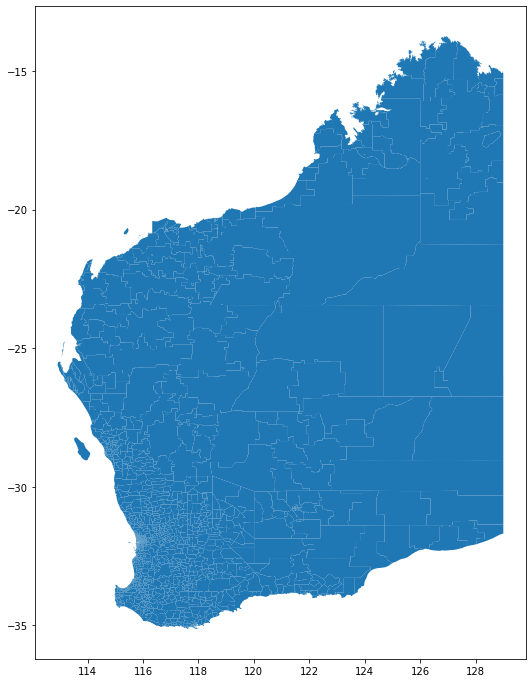

In [8]:
# Quick and dirty map of our suburbs
suburbs.plot(figsize=(12, 12))

Let's look at an individual suburb

In [9]:
suburb = suburbs[suburbs.LOC_PID == 'WA2863'].iloc[0]  # let's play with Perth's CBD
suburb

LC_PLY_PID                                                20053
DT_CREATE                                            2019-05-22
DT_RETIRE                                                  None
LOC_PID                                                  WA2863
WA_LOCALIT                                           2018-08-03
WA_LOCAL_1                                                 None
WA_LOCAL_2                                                PERTH
WA_LOCAL_3                                                 None
WA_LOCAL_4                                                 None
WA_LOCAL_5                                                    G
WA_LOCAL_6                                                 None
WA_LOCAL_7                                                    5
geometry      POLYGON ((115.86917972516 -31.95627394395, 115...
Name: 144, dtype: object

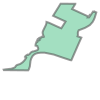

In [10]:
suburb.geometry

This geometry is a regular shapely shape and we can access a whole bunch of analytics from here. For example we can get the boundary:

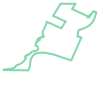

In [11]:
suburb.geometry.boundary

We could buffer on this boundary to find locations within a certain distance of the suburb edge

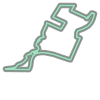

In [12]:
near_boundary = suburb.geometry.boundary.buffer(0.001)
near_boundary

If we only care about properties inside the suburb we can generate the intersection of the buffer with the suburb

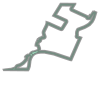

In [13]:
suburb.geometry.intersection(near_boundary)

We can also get the suburb centroid etc etc

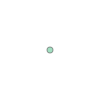

In [14]:
suburb.geometry.centroid

Basically anything you could think of doing in ArcGIS you can do in Python, with the added advantage of all the machine learning/statistical/data science libraries that you can leverage to do really complex stuff. 

Have a play with the attributes here and also take a look at the [`shapely` documentation for more spatial analysis methods](https://shapely.readthedocs.io/en/stable/manual.html#spatial-analysis-methods)

### Getting temperature data for the suburb

Next we're going to look at using Rasterio to pull out the temperature pixels for each suburb. 

Before we generate the masks we need to make sure that the polygons and the rasters have the same projection. Fortunately `geopandas` makes this easy for us:

In [15]:
# Check the initial suburb coordinate reference system
suburbs.crs

<Geographic 2D CRS: EPSG:4283>
Name: GDA94
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Australia - GDA
- bounds: (93.41, -60.56, 173.35, -8.47)
Datum: Geocentric Datum of Australia 1994
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [16]:
# Convert to EPSG 4326 (Web Mercator, aka EPSG:900913)
suburbs.to_crs(epsg=4326, inplace=True)

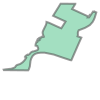

In [17]:
# Pull out our suburb again
suburb = suburbs[suburbs.LOC_PID == 'WA2863'].iloc[0]
suburb.geometry  # this will look the same but the numbers are diff

The key piece of functionality we want is in `rasterio.rasterize` (funnily enough my search for copy-paste code [led me to a GitHub issue I contributed to in 2014](https://github.com/mapbox/rasterio/issues/154) - it's nice when past you makes your job easier). Basically we create a mask for the image by burning the polygons into the raster

In [18]:
from rasterio.features import rasterize

# Generate mask using first image for metadata
mask_value = 1
fill_value = 0
with rasterio.open('../data/minaut.txt.geotiff') as src:
    mask = rasterize([(suburb.geometry.__geo_interface__, mask_value)], 
                     out_shape=src.shape, 
                     transform=src.transform, 
                     all_touched=True, 
                     fill=fill_value).astype(bool)

Note that there might not be many pixels touched by the polygon at this scale, but they're the right ones that we want!

In [19]:
numpy.count_nonzero(mask) # see how many pixels we've picked up

7

Now we can use the mask to select the relevant pixels out of the geotiff to get temperature data for the suburb for each season

In [20]:
datasets = [
    ('autumn', '../data/minaut.txt.geotiff'),
    ('spring', '../data/minspr.txt.geotiff'),
    ('summer', '../data/minsum.txt.geotiff'),
    ('winter', '../data/minwin.txt.geotiff')
]

results = {}
for key, filename in datasets:
    with rasterio.open(filename) as src:
        results[key] = src.read(1)[mask]
    
results

{'autumn': array([13.97333, 13.81   , 14.05667, 13.89   , 14.21   , 14.08333,
        13.92333]),
 'spring': array([11.18667, 11.00333, 11.28667, 11.09667, 11.48   , 11.33333,
        11.14667]),
 'summer': array([17.02   , 16.90667, 17.1    , 16.98   , 17.18333, 17.12   ,
        17.01   ]),
 'winter': array([9.236667, 9.063334, 9.323333, 9.146667, 9.49    , 9.353333,
        9.183333])}

**Exercise:** Write a function to do this data extraction for all the suburbs in the shapefile with feeding it to a machine learning pipeline in mind. The function should return a pandas dataframe with the LOC_PID of the suburbs, the coordinates of their centroids, and the mean temperatures for each season.

In [21]:
def extract_suburb_temperature(suburbs, temp_datasets, mask_value=1, fill_value=0):
    
    results = {
        'loc_pid': np.empty(4*len(suburbs), dtype=object),
        'latitude': np.empty(4*len(suburbs)),
        'longitude': np.empty(4*len(suburbs)),
        'season': np.empty(4*len(suburbs), dtype=object),
        'mean_temperature': np.empty(4*len(suburbs))
    }
    
    for i, suburb in suburbs.iterrows():
        
        print("Processing suburb", i + 1, "over", len(suburbs))

        # Generate mask using first image for metadata
        with rasterio.open('../data/minaut.txt.geotiff') as src:
            mask = rasterize([(suburb.geometry.__geo_interface__, mask_value)], 
                             out_shape=src.shape, 
                             transform=src.transform, 
                             all_touched=True, 
                             fill=fill_value).astype(bool)
        # Get the coordinates and apply the mask to the temperature datasets
        for j, (key, filename) in enumerate(temp_datasets):
            with rasterio.open(filename) as src:
                results['loc_pid'][4*i + j] = suburb['LC_PLY_PID']
                results['latitude'][4*i + j] = suburb.geometry.centroid.y
                results['longitude'][4*i + j] = suburb.geometry.centroid.x
                result = src.read(1)[mask]
                result[result == -9999.] = numpy.nan
                results['season'][4*i + j] = key
                if numpy.isnan(result).all() == False:
                    results['mean_temperature'][4*i + j] = numpy.nanmean(result)
                else:
                    results['mean_temperature'][4*i + j] = numpy.nan
                
    return pandas.DataFrame(results)

In [22]:
%%time

results = extract_suburb_temperature(suburbs, datasets)

Processing suburb 1 over 1737
Processing suburb 2 over 1737
Processing suburb 3 over 1737
Processing suburb 4 over 1737
Processing suburb 5 over 1737
Processing suburb 6 over 1737
Processing suburb 7 over 1737
Processing suburb 8 over 1737
Processing suburb 9 over 1737
Processing suburb 10 over 1737
Processing suburb 11 over 1737
Processing suburb 12 over 1737
Processing suburb 13 over 1737
Processing suburb 14 over 1737
Processing suburb 15 over 1737
Processing suburb 16 over 1737
Processing suburb 17 over 1737
Processing suburb 18 over 1737
Processing suburb 19 over 1737
Processing suburb 20 over 1737
Processing suburb 21 over 1737
Processing suburb 22 over 1737
Processing suburb 23 over 1737
Processing suburb 24 over 1737
Processing suburb 25 over 1737
Processing suburb 26 over 1737
Processing suburb 27 over 1737
Processing suburb 28 over 1737
Processing suburb 29 over 1737
Processing suburb 30 over 1737
Processing suburb 31 over 1737
Processing suburb 32 over 1737
Processing suburb

In [23]:
results.head()

,loc_pid,latitude,longitude,season,mean_temperature
0,21062,-21.081266,115.472386,autumn,NaN
1,21062,-21.081266,115.472386,spring,NaN
2,21062,-21.081266,115.472386,summer,NaN
3,21062,-21.081266,115.472386,winter,NaN
4,21053,-20.908164,116.034510,autumn,NaN


In [24]:
results.describe()

,latitude,longitude,mean_temperature
count,6948.000000,6948.000000,6484.000000
mean,-30.830100,117.039201,12.241050
std,3.923336,2.394191,4.303775
min,-35.100602,113.053438,4.647905
25%,-33.263256,115.772352,9.094946
50%,-31.927111,116.141955,11.531974
75%,-30.615281,117.711905,14.860609
max,-14.294520,128.846186,26.132778


In [25]:
results[results.season == 'autumn'].dropna()

,loc_pid,latitude,longitude,season,mean_temperature
8,21033,-20.789617,115.399195,autumn,23.141482
16,21072,-34.985727,117.951932,autumn,11.220000
20,19686,-31.983211,122.939861,autumn,11.439143
24,20187,-30.461286,119.605316,autumn,12.389434
28,20096,-29.387205,119.896390,autumn,13.843814
...,...,...,...,...,...
6928,20504,-32.062509,118.394871,autumn,11.765000
6932,19346,-28.792126,114.612869,autumn,14.826665
6936,20453,-28.798716,114.625512,autumn,14.733335
6940,19460,-20.734702,116.817568,autumn,22.054165
